# YOLO Object Detection for Fetal Anatomic Structures

## Setup

### Libraries

In [1]:
import gc
import hashlib
import json
import os
from collections import defaultdict
from typing import Optional, Iterator

import albumentations as A
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision.models as models
from PIL import Image
from dotenv import load_dotenv
from mlflow.data.dataset import Dataset as MLFLowDataset
from numpy.typing import NDArray
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard.writer import SummaryWriter
from torchvision.models.mobilenetv2 import MobileNet_V2_Weights
from tqdm.auto import tqdm
from ultralytics import YOLO

/home/gonzagrau/miniconda3/envs/iamedic/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


### Configuration

In [2]:
load_dotenv()

True

In [3]:
np.random.seed(0)

In [4]:
# Model Configuration  
TARGET_HEIGHT = 640  # YOLO works best with 640x640 (will be set automatically)
TARGET_WIDTH = 640   # YOLO typically uses square images
# Dataset Configuration
DATASET_DIR = os.getenv("DATASET_DIR")
DATASET_IMAGES_DIR_NAME = "Images"
DATASET_IMAGES_DIR = os.path.join(*[DATASET_DIR, DATASET_IMAGES_DIR_NAME])
ANNOTATIONS_PATH = os.path.join(*[DATASET_DIR, "ObjectDetection.xlsx"])
VERSIONING_FILE_NAME = "Versioning.xlsx"
VERSIONING_PATH = os.path.join(*[DATASET_DIR, VERSIONING_FILE_NAME])
DATASET_VERSION = "V1"
DATASET_TRAIN_VAL_COL = "Train + Val Filenames"
DATASET_TEST_COL = "Test Filenames"
# Experiment logging
MLFLOW_URI = os.getenv("MLFLOW_URI")
MLFLOW_EXPERIMENT_NAME = f"Fetal_Structures_yolo_{TARGET_HEIGHT}x{TARGET_WIDTH}_v0"
MLFLOW_USER = os.getenv("MLFLOW_USER")
MODEL_NAME = f"fetal_structures_yolo_{TARGET_HEIGHT}x{TARGET_WIDTH}"
# Training parameters
TRAIN_SPLIT, VAL_SPLIT = 0.8, 0.2
K_FOLDS = 1
BATCH_SIZE = 32
NUM_EPOCHS = 100
LEARNING_RATE = 1e-2
WEIGHT_DECAY = 5e-4
EARLY_STOPPING_PATIENCE = 20
# Temp dirs
CHECKPOINTS_DIR = r"./checkpoints"
if not os.path.exists(CHECKPOINTS_DIR):
    os.makedirs(CHECKPOINTS_DIR)

### Experiment Setup

In [5]:
# Logging with mlflow
if MLFLOW_URI is None:
    raise RuntimeError("MLFLOW_URI environment variable is not set.")
mlflow.set_tracking_uri(MLFLOW_URI)
MLFLOW_EXPERIMENT = mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)

2025/09/23 22:36:51 INFO mlflow.tracking.fluent: Experiment with name 'Fetal_Structures_yolo_640x640_v0' does not exist. Creating a new experiment.


In [6]:
# Setup device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

Using device: cuda


## Dataset Loading and Preprocessing

In [7]:
df = pd.read_excel(ANNOTATIONS_PATH)
ANNOTATIONS: dict[str, list[tuple[int, tuple[int, int, int, int]]]] = defaultdict(list)

STRUCTURES_TO_EXTRACT: list[str] = ["NT", "nasal bone", "nasal skin"]
STRUCTURES_TO_TRAIN_ON: list[str] = ["NT", "NB"]
STRUCTURES_UNION: list[str] = ["NT", "NB", "nasal bone", "nasal skin"]
STRUCTURE_TO_ID: dict[str, int] = {name: i for i, name in enumerate(STRUCTURES_UNION)}
ID_TO_STRUCTURE: dict[int, str] = {v: k for k, v in STRUCTURE_TO_ID.items()}
NUMBER_OF_CLASSES = len(STRUCTURES_TO_TRAIN_ON)

COLORS = plt.get_cmap('tab10', NUMBER_OF_CLASSES)
COLORS_MAP = {structure: COLORS(i) for i, structure in enumerate(STRUCTURES_TO_TRAIN_ON)}

# First, load preexisting annotations
for _, row in df.iterrows():
    fname, structure = row['fname'], row['structure']
    if row['structure'] not in STRUCTURES_TO_EXTRACT:
        continue

    class_id = STRUCTURE_TO_ID[structure]

    hmin, wmin, hmax, wmax = row['h_min'], row['w_min'], row['h_max'], row['w_max']
    box = (wmin, hmin, wmax, hmax)  # (xmin, ymin, xmax, ymax)
    ANNOTATIONS[fname].append((class_id, box))

# Then, combine nasal bone and nasal skin into by finding the smallest box that fits both
for fname, annotations in ANNOTATIONS.items():
    nasal_bone_box = None
    nasal_skin_box = None

    # Find the nasal bone and nasal skin annotations for this image
    for class_id, box in annotations:
        if ID_TO_STRUCTURE[class_id] == 'nasal bone':
            nasal_bone_box = box
        elif ID_TO_STRUCTURE[class_id] == 'nasal skin':
            nasal_skin_box = box

    # If both structures are present, create the combined NB box
    if nasal_bone_box and nasal_skin_box:
        xmin_nb = min(nasal_bone_box[0], nasal_skin_box[0])
        ymin_nb = min(nasal_bone_box[1], nasal_skin_box[1])
        xmax_nb = max(nasal_bone_box[2], nasal_skin_box[2])
        ymax_nb = max(nasal_bone_box[3], nasal_skin_box[3])

        # Add the combined box as a new annotation
        NB_class_id = STRUCTURE_TO_ID['NB']
        ANNOTATIONS[fname].append((NB_class_id, (xmin_nb, ymin_nb, xmax_nb, ymax_nb)))

        # Remove the individual nasal bone and nasal skin annotations
        ANNOTATIONS[fname] = [
            (cid, box) for cid, box in annotations
            if ID_TO_STRUCTURE[cid] not in ['nasal bone', 'nasal skin']
        ]

# Save the old mappings before updating them
OLD_ID_TO_STRUCTURE = ID_TO_STRUCTURE.copy()

# Update the conversion dicts to only include structures we're training on
STRUCTURE_TO_ID = {name: i for i, name in enumerate(STRUCTURES_TO_TRAIN_ON)}
ID_TO_STRUCTURE = {v: k for k, v in STRUCTURE_TO_ID.items()}

# Update all annotations to use the new class IDs
for fname in list(ANNOTATIONS.keys()):
    updated_annotations = []
    for old_class_id, box in ANNOTATIONS[fname]:
        structure_name = OLD_ID_TO_STRUCTURE[old_class_id]
        if structure_name in STRUCTURES_TO_TRAIN_ON:
            new_class_id = STRUCTURE_TO_ID[structure_name]
            updated_annotations.append((new_class_id, box))
    ANNOTATIONS[fname] = updated_annotations

In [8]:
print(STRUCTURE_TO_ID)
print(ID_TO_STRUCTURE)

{'NT': 0, 'NB': 1}
{0: 'NT', 1: 'NB'}


In [9]:
df.head(10)

fname   structure  h_min  w_min  h_max  w_max
0  pd_168.png     thalami    178    171    244    261
1  pd_168.png  nasal bone     96    308    111    349
2  pd_168.png      palate    133    300    205    408
3  pd_168.png  nasal skin     86    324     95    349
4  pd_168.png   nasal tip     79    345     89    376
5  pd_168.png    midbrain    247    173    328    231
6  pd_168.png          NT    385    257    418    464
7  pd_168.png          IT    301    213    328    290
8  pd_168.png          CM    345    216    367    304
9  pd_169.png   nasal tip     80    240     86    264

In [10]:
ANNOTATIONS["pd_168.png"]

[(0, (257, 385, 464, 418)), (1, (308, 86, 349, 111))]

In [11]:
TRAIN_TRANSFORMS = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3)
])

In [12]:
class YOLODatasetPreparator:
    """
    Simple class to prepare data for YOLO training.
    Focuses on converting annotations to YOLO format and saving images/labels.
    """
    
    def __init__(self, img_dir: str, img_names: list[str], annotations: dict):
        self.img_dir = img_dir
        self.img_names = img_names
        self.annotations = annotations
        self.n_imgs = len(img_names)
    
    def prepare_yolo_split(self, output_dir: str, split_name: str) -> str:
        """
        Prepare a single split (train/val/test) for YOLO.
        
        Args:
            output_dir: Base directory for YOLO dataset
            split_name: Name of the split (train/val/test)
        
        Returns:
            Path to the created dataset directory
        """
        # Create directory structure
        split_path = os.path.join(output_dir, split_name)
        images_path = os.path.join(split_path, "images")
        labels_path = os.path.join(split_path, "labels")
        
        os.makedirs(images_path, exist_ok=True)
        os.makedirs(labels_path, exist_ok=True)
        
        print(f"Preparing {split_name} split: {len(self.img_names)} images")
        
        for img_name in tqdm(self.img_names, desc=f"Processing {split_name}"):
            # Load and process image
            img_path = os.path.join(self.img_dir, img_name)
            image = Image.open(img_path).convert('L')  # Keep as grayscale initially
            original_width, original_height = image.size
            
            # Save image as RGB (YOLO expects RGB)
            rgb_image = image.convert('RGB')
            output_img_path = os.path.join(images_path, img_name)
            rgb_image.save(output_img_path)
            
            # Create YOLO format labels
            label_name = img_name.rsplit('.', 1)[0] + '.txt'
            label_path = os.path.join(labels_path, label_name)
            
            with open(label_path, 'w') as f:
                if img_name in self.annotations:
                    for class_id, (xmin, ymin, xmax, ymax) in self.annotations[img_name]:
                        # Convert to YOLO format (normalized center coordinates)
                        cx = ((xmin + xmax) / 2) / original_width
                        cy = ((ymin + ymax) / 2) / original_height
                        w = (xmax - xmin) / original_width
                        h = (ymax - ymin) / original_height
                        
                        # Write YOLO format: class_id cx cy w h
                        f.write(f"{class_id} {cx:.6f} {cy:.6f} {w:.6f} {h:.6f}\n")
        
        return split_path


def create_yolo_dataset_config(
    dataset_base_path: str,
    num_classes: int,
    class_names: list[str],
    yaml_path: str
) -> str:
    """
    Create YOLO dataset configuration YAML file.
    """
    yaml_content = f"""# Fetal Anatomic Structures Dataset
path: {dataset_base_path}  # dataset root dir
train: train/images  # train images (relative to 'path')
val: val/images  # val images (relative to 'path')
test: test/images  # test images (relative to 'path')

# Classes
nc: {num_classes}  # number of classes
names: {class_names}  # class names
"""
    
    with open(yaml_path, 'w') as f:
        f.write(yaml_content)
    
    return yaml_path


def visualize_yolo_sample(img_path: str, label_path: str, class_names: list[str]):
    """
    Visualize a YOLO format sample (image + labels).
    """
    # Load image
    image = Image.open(img_path)
    img_array = np.array(image)
    
    # Load labels
    boxes = []
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) == 5:
                    class_id = int(parts[0])
                    cx, cy, w, h = map(float, parts[1:5])
                    boxes.append((class_id, cx, cy, w, h))
    
    # Visualize
    fig, ax = plt.subplots(1, figsize=(10, 8))
    ax.imshow(img_array, cmap='gray' if len(img_array.shape) == 2 else None)
    
    img_height, img_width = img_array.shape[:2]
    colors = plt.get_cmap('tab10', len(class_names))
    
    for class_id, cx, cy, w, h in boxes:
        # Convert normalized coordinates to pixel coordinates
        x_center = cx * img_width
        y_center = cy * img_height
        box_width = w * img_width
        box_height = h * img_height
        
        # Convert to top-left corner
        x = x_center - box_width / 2
        y = y_center - box_height / 2
        
        # Draw rectangle
        color = colors(class_id)
        rect = patches.Rectangle((x, y), box_width, box_height,
                               linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        
        # Add label
        class_name = class_names[class_id] if class_id < len(class_names) else f"Class_{class_id}"
        ax.text(x, y - 5, class_name, color=color, fontsize=10, fontweight='bold')
    
    ax.set_title(f'YOLO Sample: {os.path.basename(img_path)}')
    ax.axis('off')
    plt.tight_layout()
    plt.show()

In [13]:
class ImageListDataset(MLFLowDataset):
    def __init__(
            self,
            names: list[str],
            source: str = VERSIONING_FILE_NAME,
            version: str = DATASET_VERSION
    ):
        self._names = names
        self._source = source
        self._version = version

    def to_dict(self):
        return {
            "name": "image_list_dataset",
            "digest": hashlib.md5(",".join(self._names).encode()).hexdigest(),
            "source_type": "inline",
            "source": self._source,
            "schema": None,
            "profile": json.dumps({
                "version": self._version,
                "num_images": len(self._names),
                "filenames": self._names
            }),
        }

In [14]:
# Dataset preparation functions are now integrated into YOLODatasetPreparator class above

In [15]:
VERSIONING_DF = pd.read_excel(VERSIONING_PATH, sheet_name=DATASET_VERSION)
TRAIN_VAL_IMG_NAMES = VERSIONING_DF[DATASET_TRAIN_VAL_COL].dropna().tolist()
TEST_IMG_NAMES = VERSIONING_DF[DATASET_TEST_COL].dropna().tolist()

In [16]:
if DATASET_DIR is None:
    raise RuntimeError("DATASET_DIR environment variable is not set.")

print(f"Loaded {len(TRAIN_VAL_IMG_NAMES)} train/val images")
print(f"Loaded {len(TEST_IMG_NAMES)} test images")
print(f"Found annotations for {len(ANNOTATIONS)} images")

# Create dataset preparators
train_val_preparator = YOLODatasetPreparator(
    img_dir=DATASET_IMAGES_DIR,
    img_names=TRAIN_VAL_IMG_NAMES,
    annotations=ANNOTATIONS
)

test_preparator = YOLODatasetPreparator(
    img_dir=DATASET_IMAGES_DIR,
    img_names=TEST_IMG_NAMES,
    annotations=ANNOTATIONS
)

Loaded 1372 train/val images
Loaded 312 test images
Found annotations for 1129 images


In [17]:
def preview_sample_annotations(img_names: list[str], annotations: dict, img_dir: str, num_samples: int = 3):
    """
    Preview sample images with their annotations before YOLO conversion.
    """
    sample_names = np.random.choice(img_names, size=min(num_samples, len(img_names)), replace=False)
    
    for img_name in sample_names:
        img_path = os.path.join(img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        img_array = np.array(image)
        
        fig, ax = plt.subplots(1, figsize=(10, 8))
        ax.imshow(img_array, cmap='gray' if len(img_array.shape) == 2 else None)
        
        # Plot annotations if they exist
        if img_name in annotations:
            img_height, img_width = img_array.shape[:2]
            
            for class_id, (xmin, ymin, xmax, ymax) in annotations[img_name]:
                structure_name = ID_TO_STRUCTURE[class_id]
                color = COLORS_MAP[structure_name]
                
                # Draw rectangle
                rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                       linewidth=2, edgecolor=color, facecolor='none')
                ax.add_patch(rect)
                
                # Add label
                ax.text(xmin, ymin - 5, structure_name, color=color, 
                       fontsize=10, fontweight='bold')
        
        ax.set_title(f'Sample: {img_name}')
        ax.axis('off')
        plt.tight_layout()
        plt.show()

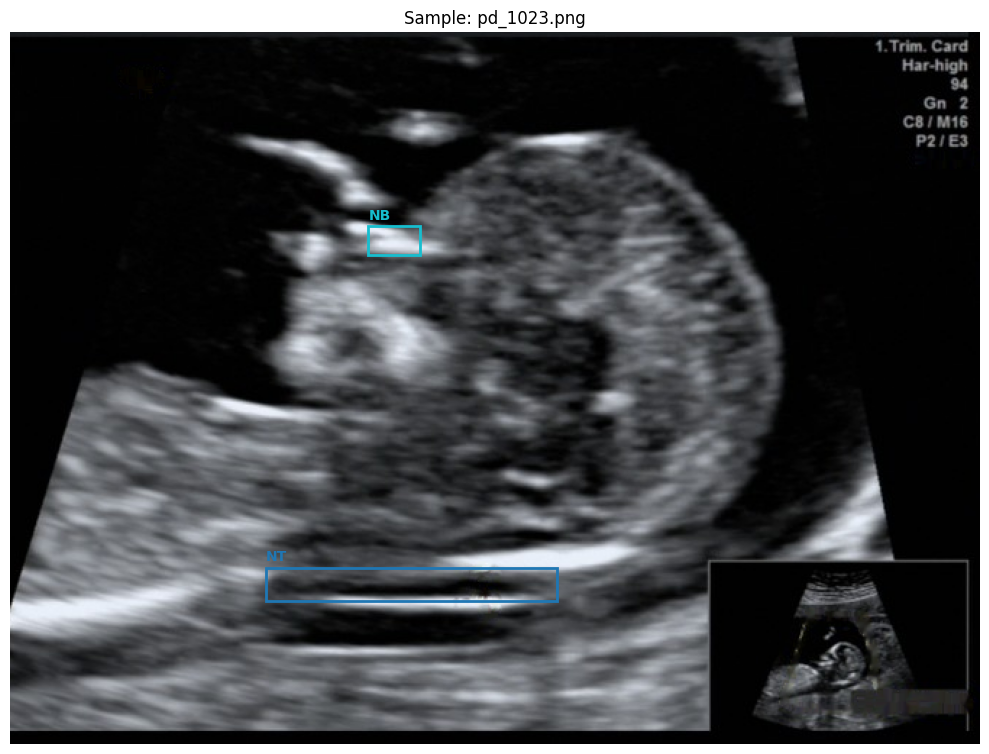

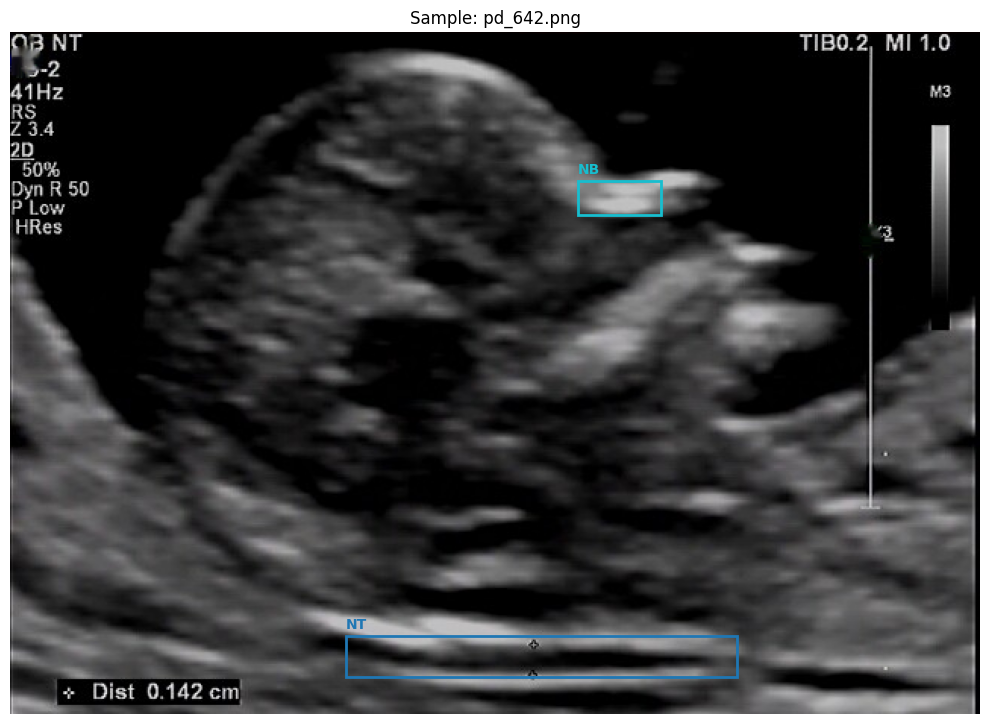

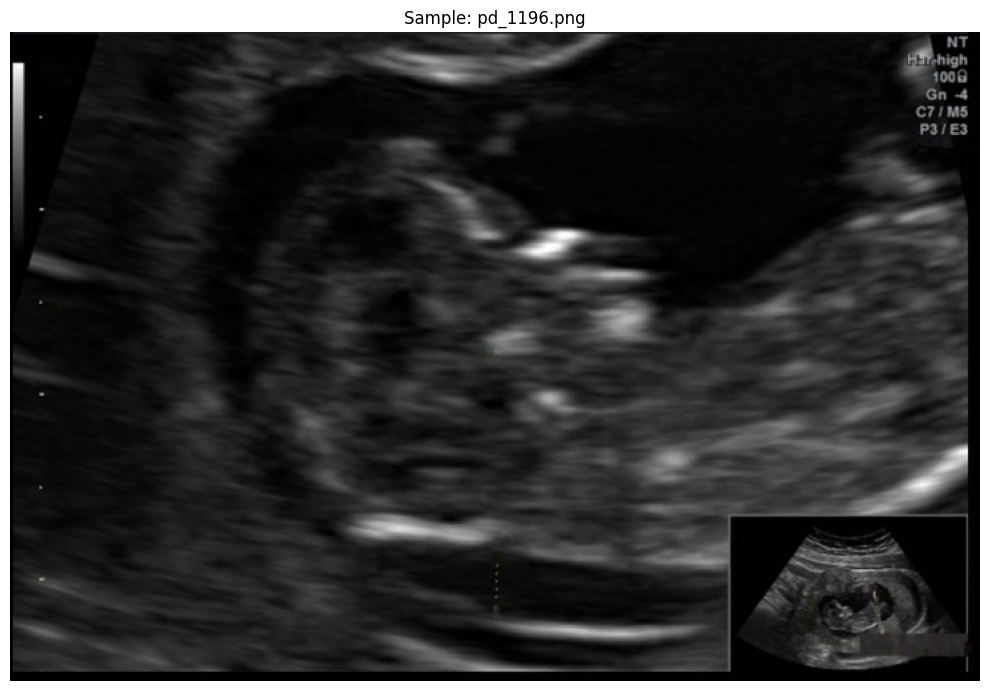

In [18]:
# Preview some sample annotations
preview_sample_annotations(TRAIN_VAL_IMG_NAMES, ANNOTATIONS, DATASET_IMAGES_DIR, num_samples=3)

## Model Definition

In [19]:
# YOLO Dataset Setup
YOLO_DATASET_DIR = os.path.join(CHECKPOINTS_DIR, "yolo_dataset")
YOLO_CONFIG_PATH = os.path.join(CHECKPOINTS_DIR, "fetal_structures.yaml")

print("Preparing YOLO datasets...")

# Filter to only images with annotations to ensure proper train/val split
annotated_train_val_imgs = [img for img in TRAIN_VAL_IMG_NAMES 
                           if img in ANNOTATIONS and len(ANNOTATIONS[img]) > 0]

print(f"Total train+val images: {len(TRAIN_VAL_IMG_NAMES)}")
print(f"Images with annotations: {len(annotated_train_val_imgs)}")

# Shuffle to ensure random distribution
np.random.shuffle(annotated_train_val_imgs)

# Split the annotated images
train_end = int(TRAIN_SPLIT * len(annotated_train_val_imgs))
train_img_names = annotated_train_val_imgs[:train_end]
val_img_names = annotated_train_val_imgs[train_end:]

print(f"Train images: {len(train_img_names)} (all with annotations)")
print(f"Val images: {len(val_img_names)} (all with annotations)")
print(f"Test images: {len(TEST_IMG_NAMES)} (mix of annotated/non-annotated)")

# Create preparators for each split
train_preparator = YOLODatasetPreparator(DATASET_IMAGES_DIR, train_img_names, ANNOTATIONS)
val_preparator = YOLODatasetPreparator(DATASET_IMAGES_DIR, val_img_names, ANNOTATIONS) 
test_preparator = YOLODatasetPreparator(DATASET_IMAGES_DIR, TEST_IMG_NAMES, ANNOTATIONS)

# Prepare YOLO datasets
train_path = train_preparator.prepare_yolo_split(YOLO_DATASET_DIR, "train")
val_path = val_preparator.prepare_yolo_split(YOLO_DATASET_DIR, "val")
test_path = test_preparator.prepare_yolo_split(YOLO_DATASET_DIR, "test")

# Create YOLO config file
config_path = create_yolo_dataset_config(
    dataset_base_path=YOLO_DATASET_DIR,
    num_classes=NUMBER_OF_CLASSES,
    class_names=STRUCTURES_TO_TRAIN_ON,
    yaml_path=YOLO_CONFIG_PATH
)

print(f"\n✅ YOLO dataset prepared at: {YOLO_DATASET_DIR}")
print(f"✅ YOLO config created at: {config_path}")

# Initialize YOLO model
model = YOLO("yolov8n.pt")  # or yolov8s.pt, yolov8m.pt for larger models
print("✅ YOLO model initialized")

Preparing YOLO datasets...
Total train+val images: 1372
Images with annotations: 1055
Train images: 844 (all with annotations)
Val images: 211 (all with annotations)
Test images: 312 (mix of annotated/non-annotated)
Preparing train split: 844 images


Processing train:   0%|          | 0/844 [00:00<?, ?it/s]

Preparing val split: 211 images


Processing val:   0%|          | 0/211 [00:00<?, ?it/s]

Preparing test split: 312 images


Processing test:   0%|          | 0/312 [00:00<?, ?it/s]


✅ YOLO dataset prepared at: ./checkpoints/yolo_dataset
✅ YOLO config created at: ./checkpoints/fetal_structures.yaml
✅ YOLO model initialized



📸 Previewing YOLO format samples:


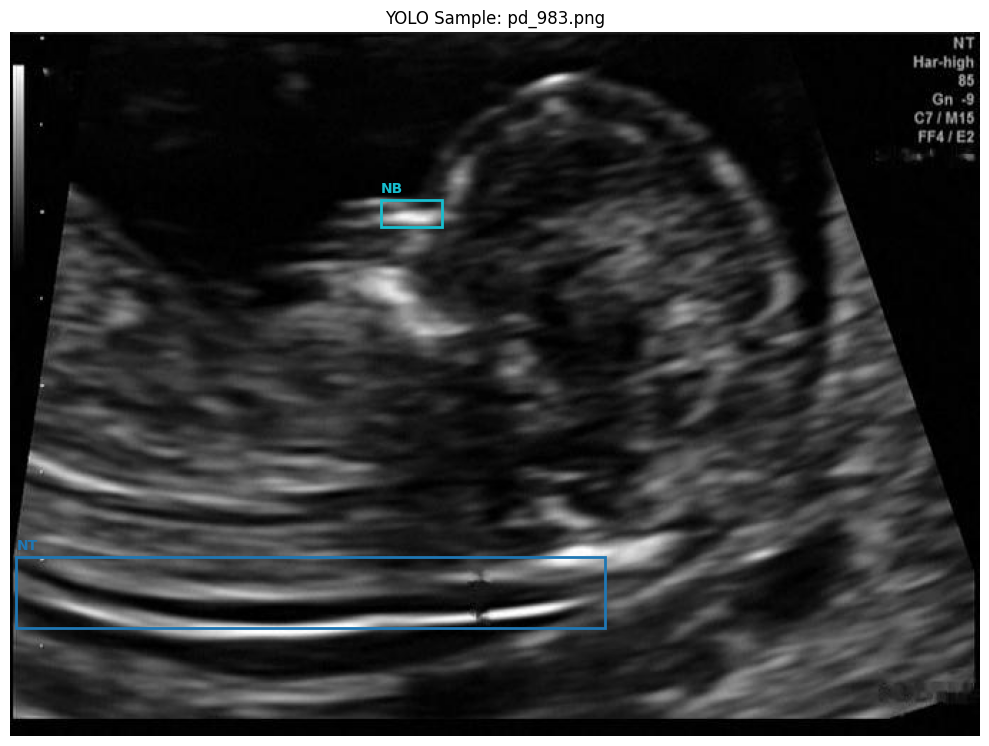

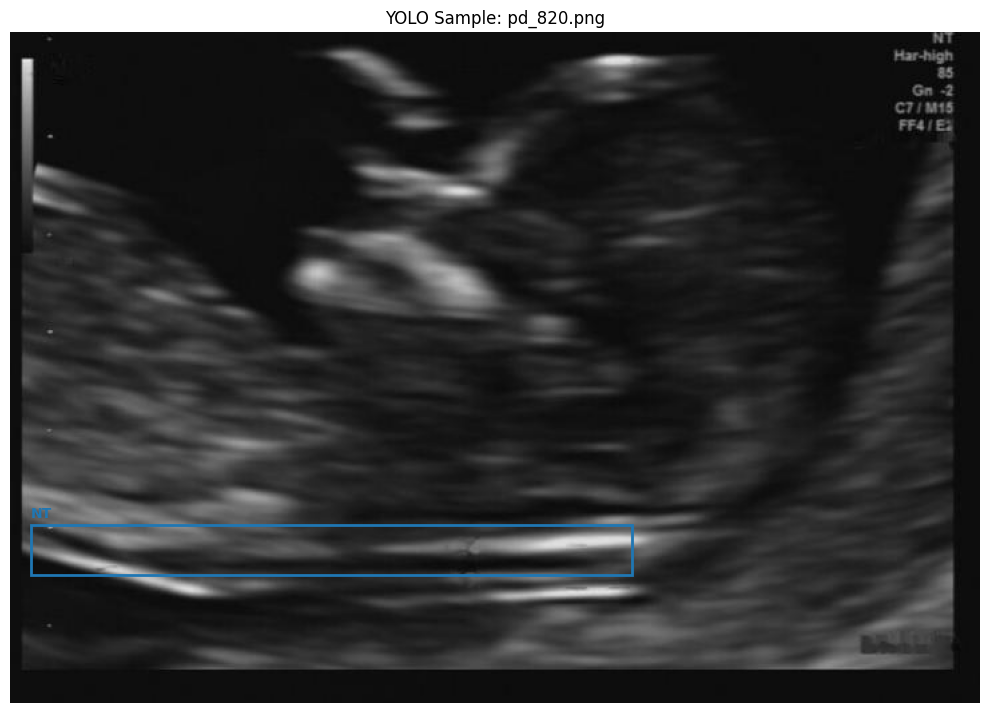

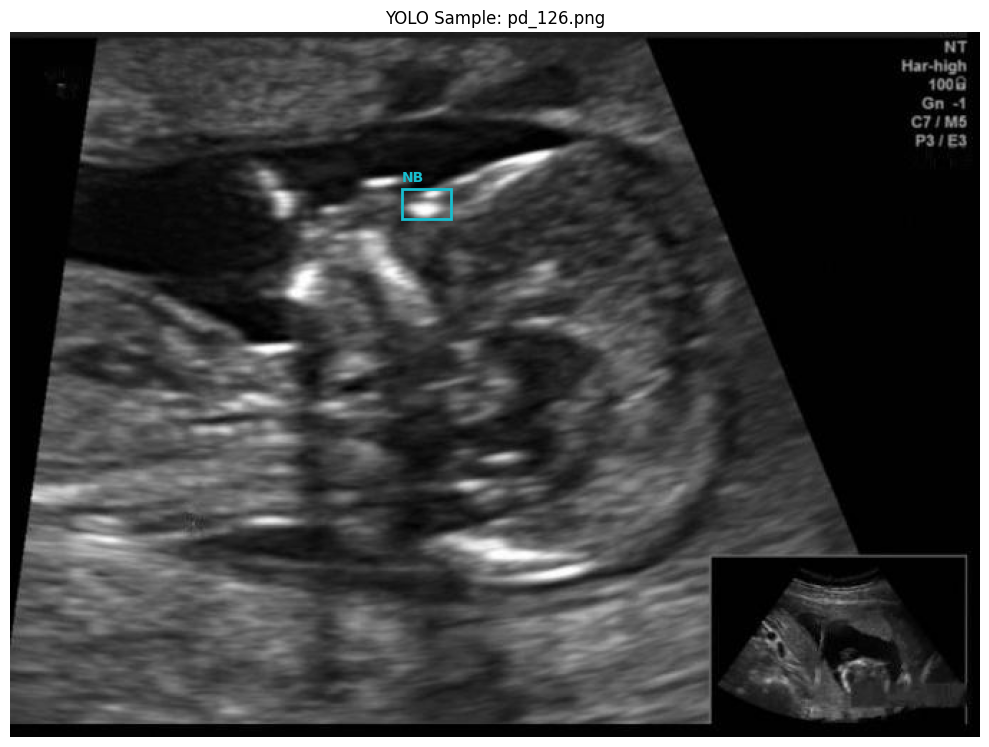

In [20]:
# Visualize some YOLO format samples
print("\n📸 Previewing YOLO format samples:")

# Get some sample files from the training set
train_images_dir = os.path.join(YOLO_DATASET_DIR, "train", "images")
train_labels_dir = os.path.join(YOLO_DATASET_DIR, "train", "labels")

if os.path.exists(train_images_dir):
    sample_files = os.listdir(train_images_dir)[:3]  # Show first 3 samples
    
    for img_file in sample_files:
        img_path = os.path.join(train_images_dir, img_file)
        label_file = img_file.rsplit('.', 1)[0] + '.txt'
        label_path = os.path.join(train_labels_dir, label_file)
        
        visualize_yolo_sample(img_path, label_path, STRUCTURES_TO_TRAIN_ON)
else:
    print("⚠️  Training images not found. Make sure to run the dataset preparation cell above.")

## Training and Evaluation

### Metrics

In [21]:
def box_iou(box1: torch.Tensor, box2: torch.Tensor) -> float:
    # box1, box2: (cx, cy, w, h) in normalized [0, 1]
    box1 = box1.clone()
    box2 = box2.clone()
    x1_min = float(box1[0] - box1[2] / 2)
    y1_min = float(box1[1] - box1[3] / 2)
    x1_max = float(box1[0] + box1[2] / 2)
    y1_max = float(box1[1] + box1[3] / 2)
    x2_min = float(box2[0] - box2[2] / 2)
    y2_min = float(box2[1] - box2[3] / 2)
    x2_max = float(box2[0] + box2[2] / 2)
    y2_max = float(box2[1] + box2[3] / 2)
    inter_xmin = max(x1_min, x2_min)
    inter_ymin = max(y1_min, y2_min)
    inter_xmax = min(x1_max, x2_max)
    inter_ymax = min(y1_max, y2_max)
    inter_area = max(0, inter_xmax - inter_xmin) * max(0, inter_ymax - inter_ymin)
    area1 = (x1_max - x1_min) * (y1_max - y1_min)
    area2 = (x2_max - x2_min) * (y2_max - y2_min)
    union = area1 + area2 - inter_area
    return inter_area / union if union > 0 else 0.0


def compute_map_per_image(
        gt_mask: torch.Tensor,
        gt_boxes: torch.Tensor,
        pred_mask: torch.Tensor,
        pred_boxes: torch.Tensor,
        iou_thresh: float = 0.5
) -> float:
    aps = []
    for k in range(gt_mask.shape[0]):
        gt_present = gt_mask[k].item() == 1
        pred_present = pred_mask[k].item() > 0.5
        if gt_present and pred_present:
            iou = box_iou(gt_boxes[k], pred_boxes[k])
            aps.append(1.0 if iou >= iou_thresh else 0.0)
        elif not gt_present and not pred_present:
            continue  # true negative
        else:
            aps.append(0.0)  # either FN or FP
    return sum(aps) / len(aps) if aps else 0.0


### YOLO Training

### Training Loop

In [22]:
# 🚀 YOLO MODEL TRAINING WITH ROBUST SAVING
print("=" * 80)
print("🚀 YOLO MODEL TRAINING WITH ROBUST SAVING")
print("=" * 80)

# Initialize model training variables
best_model_checkpoint_path = None
local_model_path = None
onnx_model_path = None
model_info_path = None
training_successful = False

# Create timestamp for unique filenames
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# YOLO training parameters
yolo_train_args = {
    'data': config_path,
    'epochs': NUM_EPOCHS,
    'imgsz': max(TARGET_HEIGHT, TARGET_WIDTH),
    'batch': BATCH_SIZE,
    'lr0': LEARNING_RATE,
    'weight_decay': WEIGHT_DECAY,
    'patience': EARLY_STOPPING_PATIENCE,
    'save_period': 5,
    'project': CHECKPOINTS_DIR,
    'name': f'yolo_fetal_structures_{timestamp}',
    'exist_ok': True,
    'pretrained': True,
    'optimizer': 'AdamW',
    'verbose': True,
    'device': DEVICE if DEVICE == 'cuda' else 'cpu',
    'workers': 0,
}

print(f"📋 Training Configuration:")
print(f"   🎯 Model: YOLOv8 Nano")
print(f"   📊 Classes: {NUMBER_OF_CLASSES} ({', '.join(STRUCTURES_TO_TRAIN_ON)})")
print(f"   🖼️  Image size: {yolo_train_args['imgsz']}px")
print(f"   🔄 Epochs: {yolo_train_args['epochs']}")
print(f"   📦 Batch size: {yolo_train_args['batch']}")
print(f"   💾 Output: {yolo_train_args['project']}/{yolo_train_args['name']}")

# MLflow Training (with error handling)
mlflow_success = False
mlflow_run_id = None

try:
    print(f"\n🔄 Starting MLflow tracking...")
    with mlflow.start_run(run_name=f"{MLFLOW_USER}_yolo_{timestamp}") as run:
        mlflow_run_id = run.info.run_id
        
        # Log parameters
        mlflow.log_params({
            "model_type": "YOLOv8",
            "model_size": "nano",
            "num_classes": NUMBER_OF_CLASSES,
            "class_names": STRUCTURES_TO_TRAIN_ON,
            "train_images": len(train_img_names),
            "val_images": len(val_img_names),
            "test_images": len(TEST_IMG_NAMES),
            "timestamp": timestamp,
            **yolo_train_args
        })
        
        # Log dataset info
        mlflow.log_input(
            ImageListDataset(train_img_names, version=DATASET_VERSION),
            context="Train Set"
        )
        mlflow.log_input(
            ImageListDataset(val_img_names, version=DATASET_VERSION),
            context="Validation Set"
        )
        
        print(f"   ✅ MLflow run started: {mlflow_run_id}")
        
        # Train the model
        print(f"\n🚂 Training YOLO model...")
        results = model.train(**yolo_train_args)
        training_successful = True
        
        # Log training results
        if hasattr(results, 'results_dict'):
            for key, value in results.results_dict.items():
                if isinstance(value, (int, float)):
                    mlflow.log_metric(key, value)
        
        # Get paths to trained model
        training_dir = os.path.join(yolo_train_args['project'], yolo_train_args['name'])
        best_model_checkpoint_path = os.path.join(training_dir, 'weights', 'best.pt')
        
        if os.path.exists(best_model_checkpoint_path):
            print(f"   ✅ Training completed successfully")
            print(f"   📂 Best model: {best_model_checkpoint_path}")
            
            # Try to register model in MLflow
            try:
                mlflow.log_artifact(best_model_checkpoint_path)
                print(f"   ✅ Model logged to MLflow")
                mlflow_success = True
            except Exception as mlflow_error:
                print(f"   ⚠️  MLflow artifact logging failed: {mlflow_error}")
        else:
            raise FileNotFoundError(f"Best model not found at {best_model_checkpoint_path}")

except Exception as e:
    print(f"❌ MLflow training failed: {e}")
    print(f"   🔄 Falling back to local training...")
    
    # Fallback: train without MLflow
    try:
        if not training_successful:
            print(f"🚂 Training YOLO model (fallback mode)...")
            results = model.train(**yolo_train_args)
            training_successful = True
            
            training_dir = os.path.join(yolo_train_args['project'], yolo_train_args['name'])
            best_model_checkpoint_path = os.path.join(training_dir, 'weights', 'best.pt')
            
            if os.path.exists(best_model_checkpoint_path):
                print(f"   ✅ Fallback training completed")
                print(f"   📂 Best model: {best_model_checkpoint_path}")
            else:
                raise FileNotFoundError(f"Best model not found at {best_model_checkpoint_path}")
    except Exception as fallback_error:
        print(f"❌ Fallback training also failed: {fallback_error}")
        raise

# ROBUST MODEL SAVING (Always executed if training succeeded)
if training_successful and best_model_checkpoint_path and os.path.exists(best_model_checkpoint_path):
    print(f"\n💾 SAVING MODELS LOCALLY...")
    
    try:
        # 1. Save PyTorch model
        local_model_path = os.path.join(CHECKPOINTS_DIR, f"yolo_fetal_structures_{timestamp}.pt")
        
        # Load fresh model from best checkpoint and save
        fresh_model = YOLO(best_model_checkpoint_path)
        fresh_model.save(local_model_path)
        print(f"   ✅ PyTorch model: {local_model_path}")
        
        # 2. Export ONNX model
        try:
            onnx_export_path = fresh_model.export(
                format='onnx',
                imgsz=max(TARGET_HEIGHT, TARGET_WIDTH),
                verbose=False,
                simplify=True,
                opset=11
            )
            
            # Move ONNX to timestamped location
            onnx_model_path = os.path.join(CHECKPOINTS_DIR, f"yolo_fetal_structures_{timestamp}.onnx")
            if onnx_export_path != onnx_model_path:
                import shutil
                shutil.copy2(onnx_export_path, onnx_model_path)
            
            file_size = os.path.getsize(onnx_model_path) / (1024 * 1024)
            print(f"   ✅ ONNX model: {onnx_model_path} ({file_size:.1f} MB)")
            
        except Exception as onnx_error:
            print(f"   ⚠️  ONNX export failed: {onnx_error}")
            onnx_model_path = None
        
        # 3. Save model metadata
        model_info = {
            'timestamp': timestamp,
            'model_type': 'YOLOv8',
            'model_size': 'nano',
            'num_classes': NUMBER_OF_CLASSES,
            'class_names': STRUCTURES_TO_TRAIN_ON,
            'image_size': max(TARGET_HEIGHT, TARGET_WIDTH),
            'train_images': len(train_img_names),
            'val_images': len(val_img_names),
            'test_images': len(TEST_IMG_NAMES),
            'best_checkpoint': best_model_checkpoint_path,
            'pytorch_model': local_model_path,
            'onnx_model': onnx_model_path,
            'dataset_config': config_path,
            'mlflow_run_id': mlflow_run_id,
            'mlflow_success': mlflow_success,
            'training_args': yolo_train_args
        }
        
        model_info_path = os.path.join(CHECKPOINTS_DIR, f"model_info_{timestamp}.json")
        with open(model_info_path, 'w') as f:
            json.dump(model_info, f, indent=2)
        print(f"   ✅ Model info: {model_info_path}")
        
        # Summary
        print(f"\n🎉 MODEL TRAINING & SAVING COMPLETE!")
        print(f"   🏆 Best checkpoint: {best_model_checkpoint_path}")
        print(f"   🔥 PyTorch model: {local_model_path}")
        print(f"   ⚡ ONNX model: {onnx_model_path if onnx_model_path else 'Failed'}")
        print(f"   📋 Model info: {model_info_path}")
        print(f"   🌟 MLflow: {'✅ Success' if mlflow_success else '⚠️  Fallback used'}")
        
    except Exception as save_error:
        print(f"❌ Model saving failed: {save_error}")
        print(f"   📂 But training checkpoint available at: {best_model_checkpoint_path}")

else:
    print(f"❌ TRAINING FAILED - No model to save")
    raise RuntimeError("Model training was not successful")

🚀 YOLO MODEL TRAINING WITH ROBUST SAVING
📋 Training Configuration:
   🎯 Model: YOLOv8 Nano
   📊 Classes: 2 (NT, NB)
   🖼️  Image size: 640px
   🔄 Epochs: 100
   📦 Batch size: 32
   💾 Output: ./checkpoints/yolo_fetal_structures_20250923_223741

🔄 Starting MLflow tracking...
   ✅ MLflow run started: 2c81780a35b6463e827c1b20c47c653b

🚂 Training YOLO model...
Ultralytics 8.3.203 🚀 Python-3.12.11 torch-2.4.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060, 11918MiB)
   ✅ MLflow run started: 2c81780a35b6463e827c1b20c47c653b

🚂 Training YOLO model...
Ultralytics 8.3.203 🚀 Python-3.12.11 torch-2.4.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060, 11918MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./checkpoints/fetal_structures.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, 

2025/09/23 22:37:43 INFO mlflow.tracking.fluent: Experiment with name './checkpoints' does not exist. Creating a new experiment.


MLflow: logging run_id(2c81780a35b6463e827c1b20c47c653b) to https://331460499657.ngrok-free.app
MLflow: disable with 'yolo settings mlflow=False'
MLflow: disable with 'yolo settings mlflow=False'
WARNING ⚠️ MLflow: Failed to initialize: API request to https://331460499657.ngrok-free.app/api/2.0/mlflow/runs/log-batch failed with exception HTTPSConnectionPool(host='331460499657.ngrok-free.app', port=443): Max retries exceeded with url: /api/2.0/mlflow/runs/log-batch (Caused by ResponseError('too many 500 error responses'))
WARNING ⚠️ MLflow: Not tracking this run
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to /home/gonzagrau/Documents/ITBA/PFC/bb-regression-model/checkpoints/yolo_fetal_structures_20250923_223741
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
WARNING ⚠️ MLflow: Failed to initialize: API request to https://331460499657.ngrok-free.app/api/2.0/mlflow/runs/log-batch failed with e

RuntimeError: Model training was not successful

## Evaluation

In [ ]:
# 🔍 LOAD BEST MODEL FOR EVALUATION
print("=" * 60)
print("🔍 LOADING BEST MODEL FOR EVALUATION")
print("=" * 60)

# Check if we have a model from training
if 'best_model_checkpoint_path' in locals() and best_model_checkpoint_path and os.path.exists(best_model_checkpoint_path):
    print(f"📂 Using model from training: {best_model_checkpoint_path}")
    best_model = YOLO(best_model_checkpoint_path)
    
elif 'local_model_path' in locals() and local_model_path and os.path.exists(local_model_path):
    print(f"📂 Using saved local model: {local_model_path}")
    best_model = YOLO(local_model_path)
    
else:
    # Fallback: find the most recent model
    import glob
    
    # Look for best.pt files in training directories
    weight_dirs = glob.glob(os.path.join(CHECKPOINTS_DIR, "yolo_fetal_structures_*/weights/best.pt"))
    if weight_dirs:
        best_model_checkpoint_path = sorted(weight_dirs)[-1]
        print(f"📂 Using most recent checkpoint: {best_model_checkpoint_path}")
        best_model = YOLO(best_model_checkpoint_path)
           if not (os.path.exists(checkpoint_path) and os.path.isfile(checkpoint_path)):
        print('Checkpoint path is invalid or does not exist.')

    export_model_to_onnx(checkpoint_path, output_path)
    visualize_onnx_model_preds(output_path, image_path)
    print("ONNX model inference and visualization complete.") 
    else:
        # Look for saved .pt files
        recent_models = glob.glob(os.path.join(CHECKPOINTS_DIR, "yolo_fetal_structures_*.pt"))
        if recent_models:
            model_path = sorted(recent_models)[-1]
            print(f"📂 Using most recent saved model: {model_path}")
            best_model = YOLO(model_path)
            best_model_checkpoint_path = model_path
            
        else:
            raise FileNotFoundError("❌ No trained models found! Please run the training cell first.")

print(f"✅ Model loaded successfully")
print(f"   📊 Model type: {type(best_model)}")
print(f"   🎯 Classes: {best_model.names if hasattr(best_model, 'names') else 'Unknown'}")
print(f"   📁 Model path: {best_model_checkpoint_path}")

🔍 LOADING BEST MODEL FOR EVALUATION
📂 Using most recent checkpoint: ./checkpoints/yolo_fetal_structures_20250923_223741/weights/best.pt
✅ Model loaded successfully
   📊 Model type: <class 'ultralytics.models.yolo.model.YOLO'>
   🎯 Classes: {0: 'NT', 1: 'NB'}
   📁 Model path: ./checkpoints/yolo_fetal_structures_20250923_223741/weights/best.pt


In [24]:
def draw_box(
        ax: plt.Axes,  # type: ignore
        cx: float,
        cy: float,
        w: float,
        h: float,
        img_w: int,
        img_h: int,
        label: str,
        color: str,
        style='solid'
):
    cx_px = cx * img_w
    cy_px = cy * img_h
    w_px = w * img_w
    h_px = h * img_h
    x = cx_px - w_px / 2
    y = cy_px - h_px / 2
    rect = patches.Rectangle((x, y), w_px, h_px,
                             linewidth=2,
                             edgecolor=color,
                             facecolor='none',
                             linestyle=style)
    ax.add_patch(rect)
    ax.text(x, y - 5, label, color=color, fontsize=8)

In [52]:
@torch.no_grad()
def visualize_yolo_prediction(
        model: YOLO,
        img_path: str,
        annotations: dict,
        img_name: str,
        conf_threshold: float = 0.5
):
    """
    Visualize YOLO predictions vs ground truth for a single image.
    """
    # Load image
    image = Image.open(img_path).convert('RGB')
    img_array = np.array(image)
    
    # Get YOLO predictions
    results = model.predict(image, conf=conf_threshold, verbose=False)
    
    # Visualization
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(img_array)
    
    # Plot ground truth boxes (solid lines)
    if img_name in annotations:
        for class_id, (xmin, ymin, xmax, ymax) in annotations[img_name]:
            structure_name = ID_TO_STRUCTURE[class_id]
            color = COLORS_MAP[structure_name]
            
            # Draw GT rectangle
            rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   linewidth=3, edgecolor=color, facecolor='none', linestyle='-')
            ax.add_patch(rect)
            ax.text(xmin, ymin - 10, f"{structure_name} (GT)", color=color, 
                   fontsize=10, fontweight='bold', bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))
    
    # Plot YOLO predictions (dashed lines)
    if len(results) > 0 and results[0].boxes is not None:
        boxes = results[0].boxes
        img_height, img_width = img_array.shape[:2]
        
        for i in range(len(boxes)):
            # Get box in xyxy format
            x1, y1, x2, y2 = boxes.xyxy[i].cpu().numpy()
            conf = float(boxes.conf[i].cpu().numpy())
            class_id = int(boxes.cls[i].cpu().numpy())
            
            if class_id < len(ID_TO_STRUCTURE):
                structure_name = ID_TO_STRUCTURE[class_id]
                color = COLORS_MAP[structure_name]
                
                # Draw prediction rectangle
                rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                       linewidth=3, edgecolor=color, facecolor='none', linestyle='--')
                ax.add_patch(rect)
                ax.text(x1, y2 + 5, f"{structure_name} ({conf:.2f})", color=color, 
                       fontsize=10, fontweight='bold', bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))
    
    ax.set_title(f'YOLO Prediction vs Ground Truth: {img_name}', fontsize=14, fontweight='bold')
    ax.axis('off')
    plt.tight_layout()
    plt.show()


def visualize_random_test_prediction(model: YOLO, test_img_names: list[str], annotations: dict, img_dir: str):
    """
    Visualize a random test image prediction.
    """
    random_img = np.random.choice(test_img_names)
    img_path = os.path.join(img_dir, random_img)
    visualize_yolo_prediction(model, img_path, annotations, random_img)

🎯 Quick prediction on random test image:


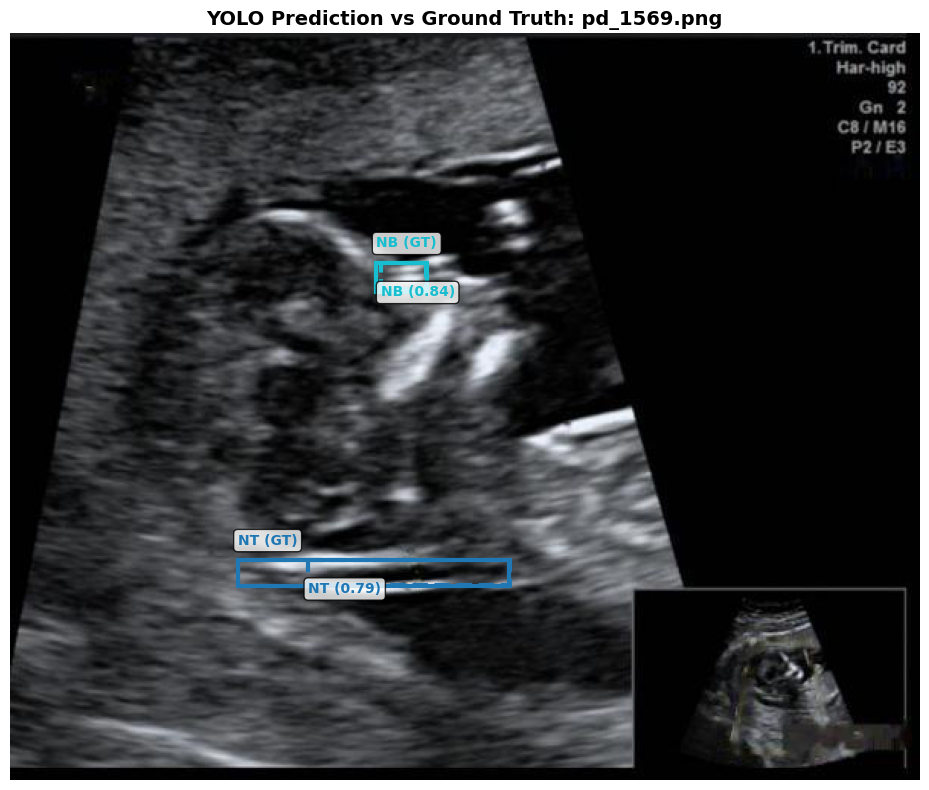

In [64]:
# 🎯 QUICK PREDICTION EXAMPLE
# This cell provides a quick way to test the model on a single random image

# Ensure we have a model loaded
if 'best_model' not in locals():
    print("⚠️  No model loaded. Please run the model loading cell first.")
else:
    # Visualize a random test prediction
    print("🎯 Quick prediction on random test image:")
    visualize_random_test_prediction(best_model, TEST_IMG_NAMES, ANNOTATIONS, DATASET_IMAGES_DIR)

In [65]:
# 📊 MODEL EVALUATION ON TEST SET
print("=" * 60)
print("📊 EVALUATING MODEL ON TEST SET")
print("=" * 60)

# Ensure we have a model loaded
if 'best_model' not in locals():
    raise RuntimeError("❌ No model loaded! Please run the model loading cell first.")

print(f"🔍 Evaluating model: {best_model_checkpoint_path}")
print(f"📊 Test set size: {len(TEST_IMG_NAMES)} images")
print(f"📋 Dataset config: {config_path}")

try:
    # Run YOLO validation on test set
    print(f"\n🚀 Running validation...")
    test_results = best_model.val(
        data=config_path, 
        split='test', 
        verbose=True,
        save_json=True,  # Save results as JSON
        plots=True       # Generate plots
    )
    
    print(f"✅ Evaluation completed successfully")
    
    # Extract and display key metrics
    if hasattr(test_results, 'results_dict'):
        results_dict = test_results.results_dict
        
        print(f"\n📈 TEST RESULTS:")
        
        # Key metrics
        metrics_to_show = [
            ('metrics/mAP50(B)', 'mAP@0.5'),
            ('metrics/mAP50-95(B)', 'mAP@0.5:0.95'),
            ('metrics/precision(B)', 'Precision'),
            ('metrics/recall(B)', 'Recall'),
            ('fitness', 'Fitness Score')
        ]
        
        for metric_key, display_name in metrics_to_show:
            if metric_key in results_dict:
                value = results_dict[metric_key]
                if isinstance(value, (int, float)):
                    print(f"   🎯 {display_name}: {value:.3f}")
        
        # Log to MLflow if we have an active run or can create one
        try:
            if mlflow.active_run() is None and 'mlflow_run_id' in locals() and mlflow_run_id:
                # Try to resume the training run
                mlflow.start_run(run_id=mlflow_run_id)
            
            if mlflow.active_run():
                print(f"\n📝 Logging results to MLflow...")
                for key, value in results_dict.items():
                    if isinstance(value, (int, float)):
                        mlflow.log_metric(f"test_{key}", value)
                print(f"   ✅ Results logged to MLflow")
                
        except Exception as mlflow_error:
            print(f"   ⚠️  MLflow logging failed: {mlflow_error}")
    
    else:
        print(f"⚠️  Results not available in expected format")
        print(f"   Available attributes: {[attr for attr in dir(test_results) if not attr.startswith('_')]}")

except Exception as eval_error:
    print(f"❌ Evaluation failed: {eval_error}")
    print(f"💡 Try running evaluation manually:")
    print(f"   best_model.val(data='{config_path}', split='test')")
    raise

📊 EVALUATING MODEL ON TEST SET
🔍 Evaluating model: ./checkpoints/yolo_fetal_structures_20250923_223741/weights/best.pt
📊 Test set size: 312 images
📋 Dataset config: ./checkpoints/fetal_structures.yaml

🚀 Running validation...
Ultralytics 8.3.203 🚀 Python-3.12.11 torch-2.4.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060, 11918MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 8634.2±901.8 MB/s, size: 175.8 KB)
val: Scanning /home/gonzagrau/Documents/ITBA/PFC/bb-regression-model/checkpoints/yolo_dataset/test/labels.cache... 312 images, 240 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 312/312 1.4Mit/s 0.0s0s
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 8634.2±901.8 MB/s, size: 175.8 KB)
val: Scanning /home/gonzagrau/Documents/ITBA/PFC/bb-regression-model/checkpoints/yolo_dataset/test/labels.cache... 312 images, 240 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 312/312 1.4Mit/s 0.0s0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 20/2

🎨 VISUALIZING MODEL PREDICTIONS
🖼️  Showing predictions on test images...
   📊 Showing 3 test images with ground truth


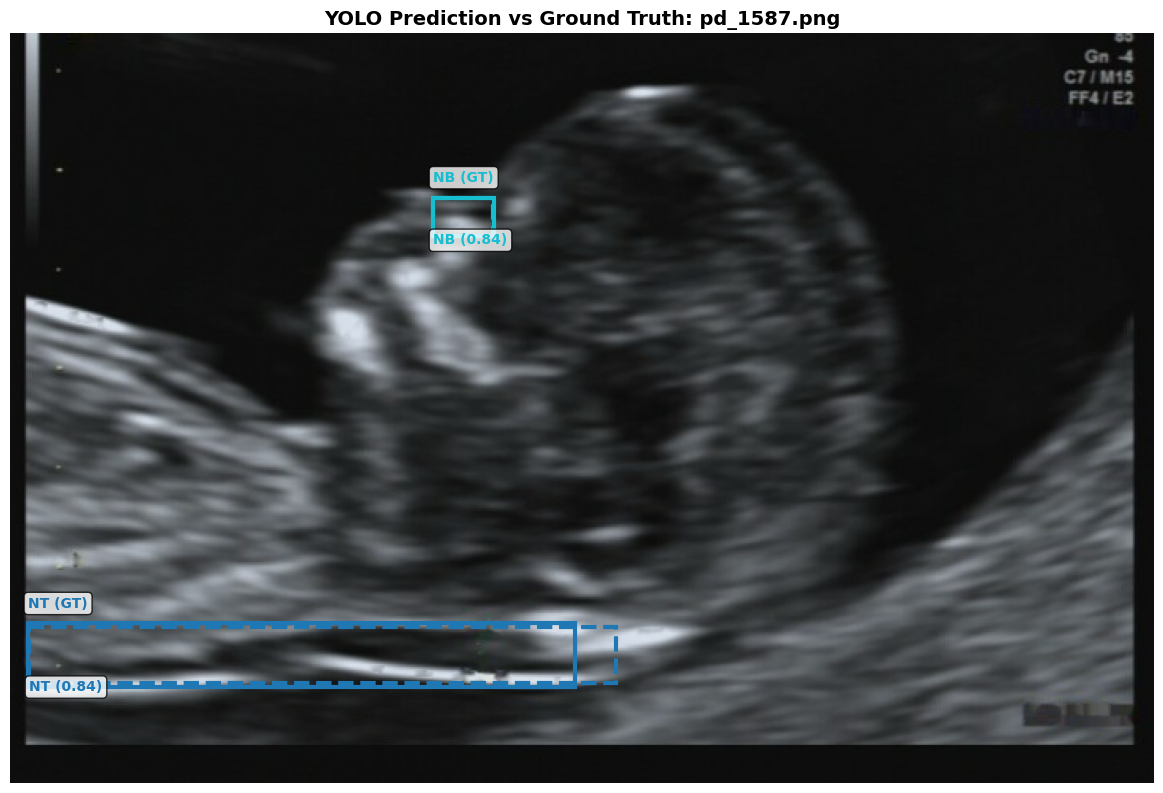

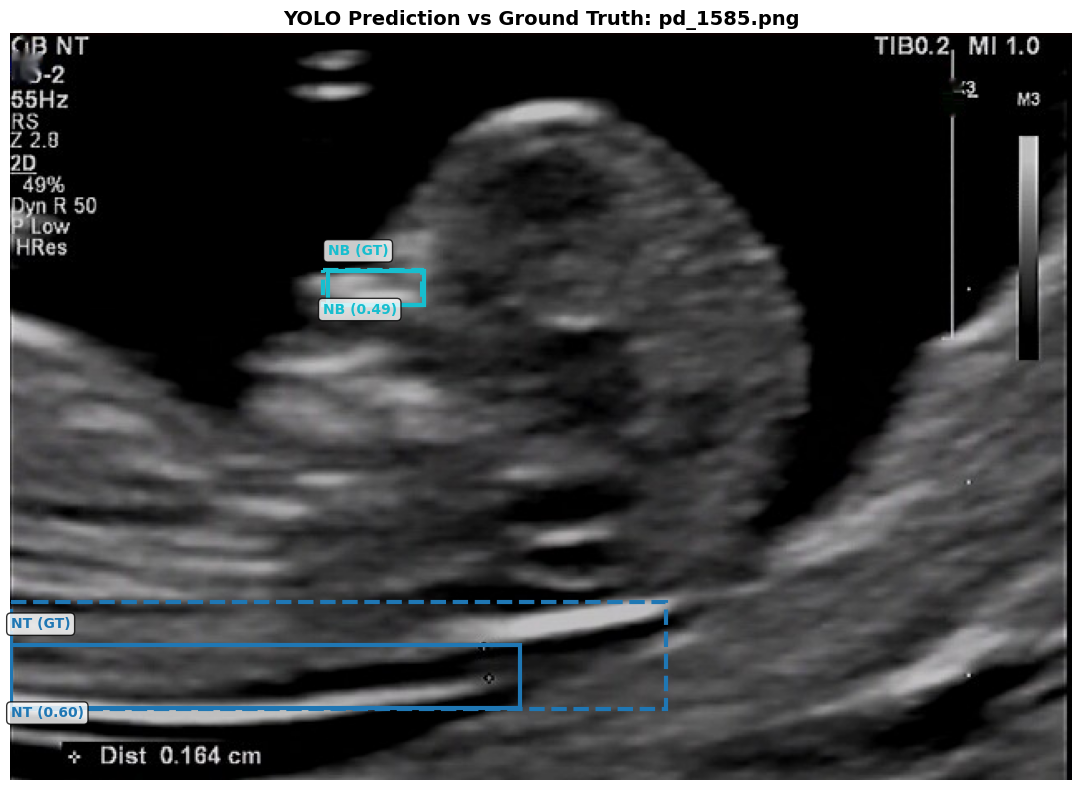

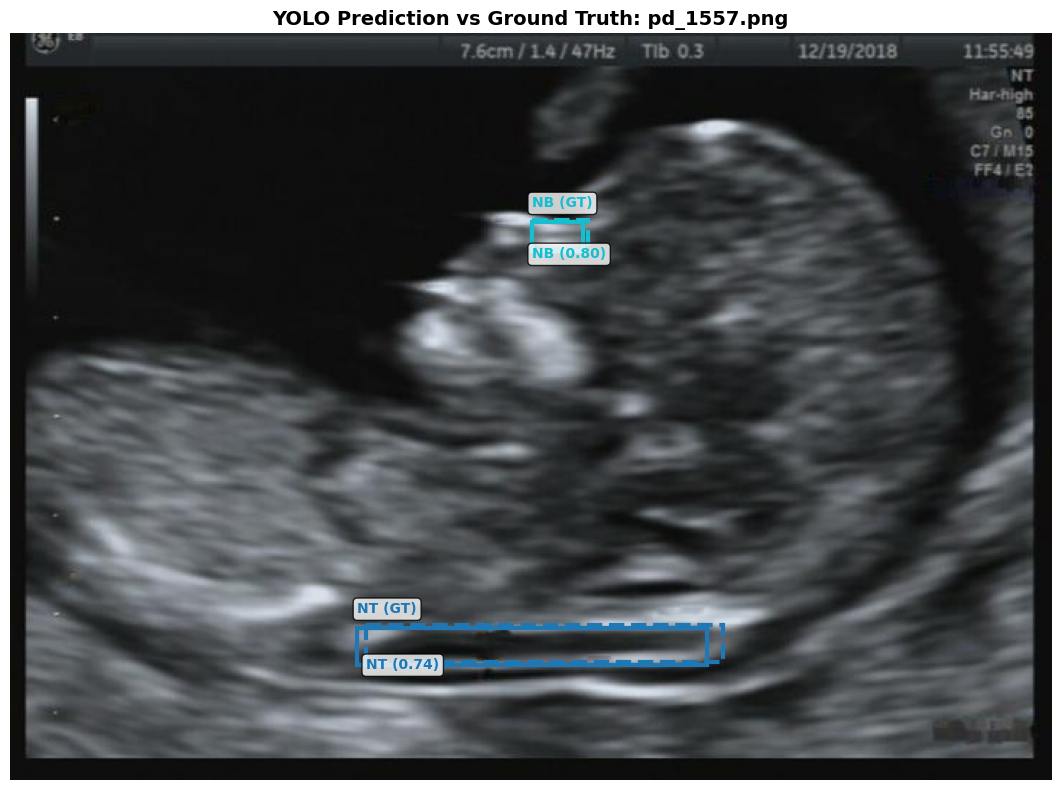

✅ Visualization completed


In [66]:
# 🎨 VISUALIZE MODEL PREDICTIONS
print("=" * 60)
print("🎨 VISUALIZING MODEL PREDICTIONS")
print("=" * 60)

# Ensure we have a model loaded
if 'best_model' not in locals():
    raise RuntimeError("❌ No model loaded! Please run the model loading cell first.")

# Show predictions on random test images
print(f"🖼️  Showing predictions on test images...")

try:
    # Select random test images with annotations (for comparison)
    test_imgs_with_annotations = [
        img for img in TEST_IMG_NAMES 
        if img in ANNOTATIONS and len(ANNOTATIONS[img]) > 0
    ]
    
    if test_imgs_with_annotations:
        # Show images with ground truth
        num_samples = min(3, len(test_imgs_with_annotations))
        sample_images = np.random.choice(test_imgs_with_annotations, size=num_samples, replace=False)
        print(f"   📊 Showing {num_samples} test images with ground truth")
        
        for img_name in sample_images:
            img_path = os.path.join(DATASET_IMAGES_DIR, img_name)
            if os.path.exists(img_path):
                visualize_yolo_prediction(best_model, img_path, ANNOTATIONS, img_name, conf_threshold=0.3)
            else:
                print(f"   ⚠️  Image not found: {img_path}")
    else:
        # Show random test images without ground truth comparison
        num_samples = min(3, len(TEST_IMG_NAMES))
        sample_images = np.random.choice(TEST_IMG_NAMES, size=num_samples, replace=False)
        print(f"   📊 Showing {num_samples} random test images")
        
        for img_name in sample_images:
            img_path = os.path.join(DATASET_IMAGES_DIR, img_name)
            if os.path.exists(img_path):
                # Simple prediction visualization
                image = Image.open(img_path).convert('RGB')
                results = best_model.predict(image, conf=0.3, verbose=False)
                
                # Plot results
                if len(results) > 0:
                    annotated_img = results[0].plot()
                    plt.figure(figsize=(10, 8))
                    plt.imshow(annotated_img)
                    plt.title(f'Prediction: {img_name}')
                    plt.axis('off')
                    plt.show()
                else:
                    print(f"   ⚠️  No predictions for {img_name}")
            else:
                print(f"   ⚠️  Image not found: {img_path}")
                
    print(f"✅ Visualization completed")
    
except Exception as viz_error:
    print(f"❌ Visualization failed: {viz_error}")
    print(f"💡 You can still run manual prediction:")
    print(f"   results = best_model.predict('path/to/image.jpg')")
    print(f"   results[0].show()  # Display annotated result")